<a href="https://colab.research.google.com/github/adas754/vegitable_classification/blob/main/cnn_PRO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import locale
locale.getpreferredencoding = lambda: "UTF-8"

Mounted at /content/gdrive


In [2]:
!mkdir /root/.kaggle

In [6]:
!scp '/content/gdrive/My Drive/DeepLearning-Class/kaggle.json' /root/.kaggle/

In [3]:
import os
os.listdir("/root/.kaggle")

[]

In [4]:
!scp '/content/gdrive/My Drive/DeepLearning-Class/kaggle.json' /root/.kaggle/

In [5]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

 98% 525M/534M [00:08<00:00, 113MB/s]
100% 534M/534M [00:08<00:00, 64.6MB/s]


In [6]:
!unzip /content/vegetable-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Vegetable Images/train/Radish/0001.jpg  
  inflating: Vegetable Images/train/Radish/0002.jpg  
  inflating: Vegetable Images/train/Radish/0003.jpg  
  inflating: Vegetable Images/train/Radish/0004.jpg  
  inflating: Vegetable Images/train/Radish/0005.jpg  
  inflating: Vegetable Images/train/Radish/0006.jpg  
  inflating: Vegetable Images/train/Radish/0007.jpg  
  inflating: Vegetable Images/train/Radish/0008.jpg  
  inflating: Vegetable Images/train/Radish/0009.jpg  
  inflating: Vegetable Images/train/Radish/0010.jpg  
  inflating: Vegetable Images/train/Radish/0011.jpg  
  inflating: Vegetable Images/train/Radish/0012.jpg  
  inflating: Vegetable Images/train/Radish/0013.jpg  
  inflating: Vegetable Images/train/Radish/0014.jpg  
  inflating: Vegetable Images/train/Radish/0015.jpg  
  inflating: Vegetable Images/train/Radish/0016.jpg  
  inflating: Vegetable Images/train/Radish/0017.jpg  
  inflating: Vegetable Images/t

In [7]:
## data manipulation and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## nueral network creation
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout ,GlobalAveragePooling2D
from keras.models import Sequential ##  sequential model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

## pre-trained model
from keras.applications import VGG16


from sklearn.metrics import confusion_matrix,classification_report

import os, shutil
import warnings
warnings.filterwarnings('ignore')

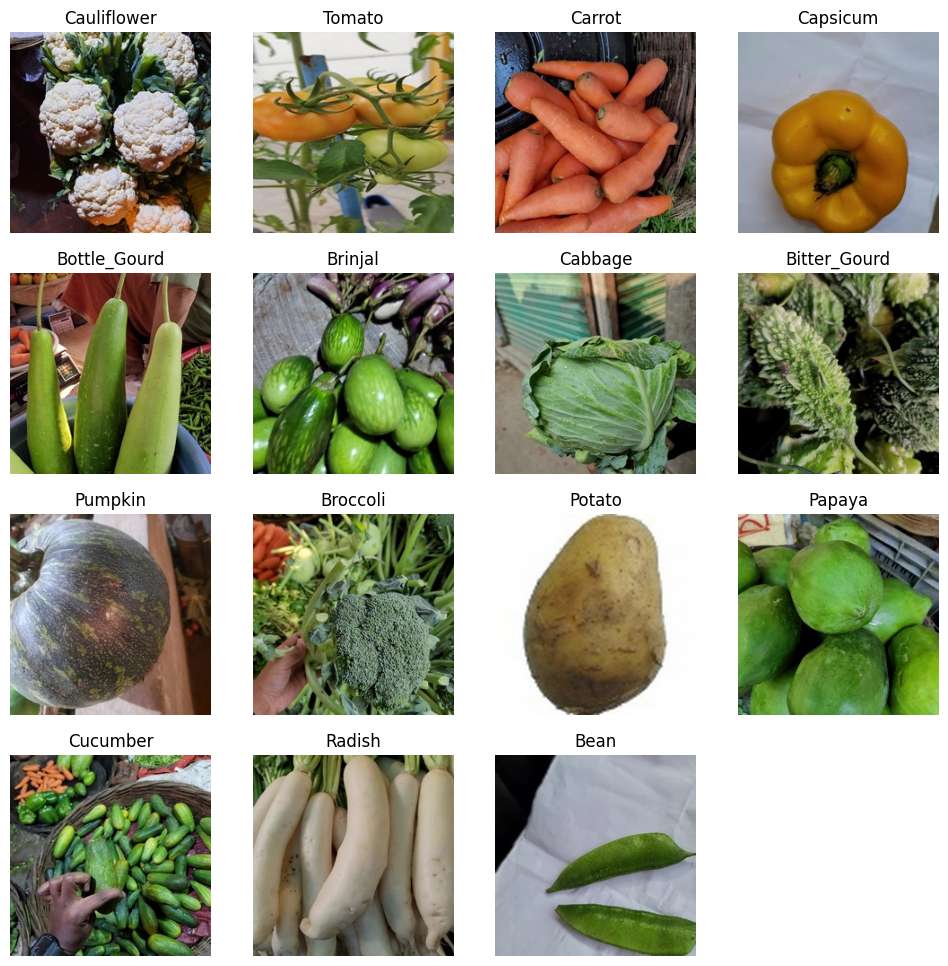

In [8]:
# Look at Vegetables
train_path = "/content/Vegetable Images/train"
validation_path = "/content/Vegetable Images/validation"
test_path = "/content/Vegetable Images/test"

image_categories = os.listdir('/content/Vegetable Images/train')

def plot_images(image_categories):

    # Create a figure
    plt.figure(figsize=(12, 12))
    for i, cat in enumerate(image_categories):

        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[i]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255


        # Create Subplot and plot the images
        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')

    plt.show()

plot_images(image_categories)

<Axes: >

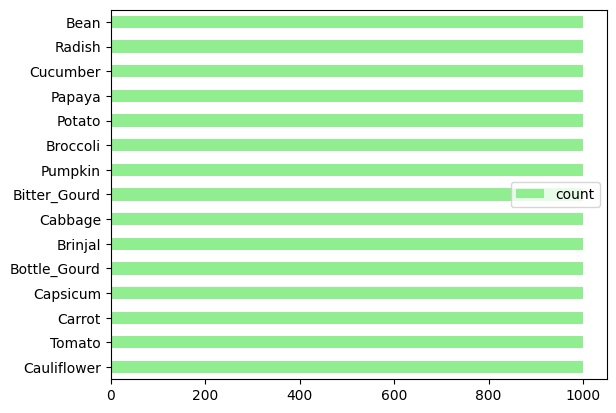

In [9]:
## target distribution in training dataset

images_length={}
for i, cat in enumerate(image_categories):

        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        images_length[cat]=len(images_in_folder)

pd.DataFrame(images_length,index = ['count']).T.plot(kind='barh',color='lightgreen')

In [10]:
''' Data Augmentation: is a process to increase training set generating new data points from existing Data. Prevents Overfitting
    Only applicable at Training Phase.
'''
# 1. Train Set
train_gen = ImageDataGenerator( featurewise_center=False,  # set input mean to 0 over the dataset
                                samplewise_center=False,  # set each sample mean to 0
                                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                samplewise_std_normalization=False,  # divide each input by its std
                                zca_whitening=False,                 # apply ZCA whitening
                                rotation_range=10,                    # randomly rotate images in the range (degrees, 0 to 180)
                                zoom_range = 0.1,                    # Randomly zoom image
                                width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                                height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                                horizontal_flip=True,  # randomly flip images
                                vertical_flip=False,
                              )
train_image_generator = train_gen.flow_from_directory(
                                            train_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

# 2. Validation Set
val_gen = ImageDataGenerator() # Normalise the data
val_image_generator = val_gen.flow_from_directory(
                                            validation_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

#3. Testing Set
test_gen = ImageDataGenerator() # Normalise the data
test_image_generator = test_gen.flow_from_directory(
                                            validation_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')


Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [11]:
''' encoding labels '''

class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])
print(class_map)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


In [12]:
## start building model from scratch

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


## flatten layer
model.add(Flatten())

## fully connected layers
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(512,activation='relu'))

## output layer
model.add(Dense(15, activation = "softmax"))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 96)        0

In [13]:
# Compile and fit the model
'''
 Early Stopping : is a regularization technique which is used to prevent overfitting and improve generalization performance.
 The Basic Idea is that to monitor the model's performance on validation data , if performances are not improving

 '''
early_stopping = keras.callbacks.EarlyStopping(patience=3,monitor='val_loss',restore_best_weights=True) # Set up callbacks


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics='accuracy')
hist = model.fit(train_image_generator,
                 epochs=50,
                 verbose=1,
                 validation_data=val_image_generator,
                 steps_per_epoch = 15000//32,
                 validation_steps = 3000//32,
                  callbacks=early_stopping,
                 workers=4
                )

Epoch 1/50
468/468 [==============================] - 116s 228ms/step - loss: 1.4626 - accuracy: 0.5320 - val_loss: 1.9377 - val_accuracy: 0.4261
Epoch 2/50
468/468 [==============================] - 104s 220ms/step - loss: 0.7651 - accuracy: 0.7580 - val_loss: 1.6927 - val_accuracy: 0.5477
Epoch 3/50
468/468 [==============================] - 107s 226ms/step - loss: 0.5226 - accuracy: 0.8358 - val_loss: 0.4954 - val_accuracy: 0.8317
Epoch 4/50
468/468 [==============================] - 103s 218ms/step - loss: 0.3758 - accuracy: 0.8817 - val_loss: 0.3775 - val_accuracy: 0.8696
Epoch 5/50
468/468 [==============================] - 102s 217ms/step - loss: 0.2982 - accuracy: 0.9089 - val_loss: 0.2494 - val_accuracy: 0.9214
Epoch 6/50
468/468 [==============================] - 99s 209ms/step - loss: 0.2413 - accuracy: 0.9269 - val_loss: 0.3581 - val_accuracy: 0.8642
Epoch 7/50
468/468 [==============================] - 107s 228ms/step - loss: 0.2036 - accuracy: 0.9381 - val_loss: 0.3692 - 

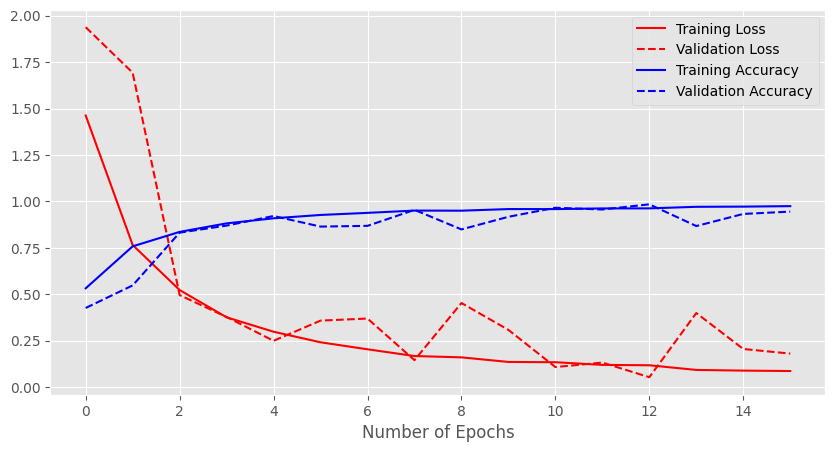

In [14]:
## helper function to plot......
def plot(hist):
    h = hist.history
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 5))
    plt.plot(h['loss'], c='red', label='Training Loss')
    plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
    plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
    plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')
    plt.xlabel("Number of Epochs")
    plt.legend(loc='best')
    plt.show()

## helper function to get accuracy of the model
def eval_(model):
    test_loss, test_acc =model.evaluate(test_image_generator)
    return f'Model Test loss : {np.round(test_loss,2)} and Test Accuracy : {np.round(test_acc,2)} '
plot(hist)


In [15]:
print(eval_(model))

94/94 [==============================] - 3s 35ms/step - loss: 0.0530 - accuracy: 0.9843
Model Test loss : 0.05 and Test Accuracy : 0.98 


In [16]:
'''
1. Create base model
2. use imagent weights (or) else
3. Remove fully connected layers after removing now base model acts as a powerful feature extractor.
'''

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

# Frezzing all the layers which prevents the weights being updated
for layer in base_model.layers:
    layer.trainable = False

## Add new layers to the Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(15, activation='softmax')
])


early_stopping = keras.callbacks.EarlyStopping(patience=2,monitor='val_loss',restore_best_weights=True,min_delta=0.1) # Set up callbacks

## compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics='accuracy')

##fit the model
hist = model.fit(train_image_generator,
                 epochs=20,
                 verbose=1,
                 validation_data=val_image_generator,
                 steps_per_epoch = 15000//32,
                 validation_steps = 3000//32,
                 callbacks=early_stopping,
                workers=4)


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
468/468 [==============================] - 109s 218ms/step - loss: 1.7177 - accuracy: 0.4936 - val_loss: 0.5817 - val_accuracy: 0.8750
Epoch 2/20
468/468 [==============================] - 98s 207ms/step - loss: 0.6795 - accuracy: 0.8282 - val_loss: 0.2832 - val_accuracy: 0.9311
Epoch 3/20
468/468 [==============================] - 102s 217ms/step - loss: 0.4288 - accuracy: 0.8851 - val_loss: 0.1817 - val_accuracy: 0.9550
Epoch 4/20
468/468 [==============================] - 99s 211ms/step - loss: 0.3083 - accuracy: 0.9172 - val_loss: 0.1295 - val_accuracy: 0.9651
Epoch 5/20
468/468 [==============================] - 102s 218ms/step - loss: 0.2444 - accuracy: 0.9339 - val_loss: 0.0988 - val_accuracy: 0.9704


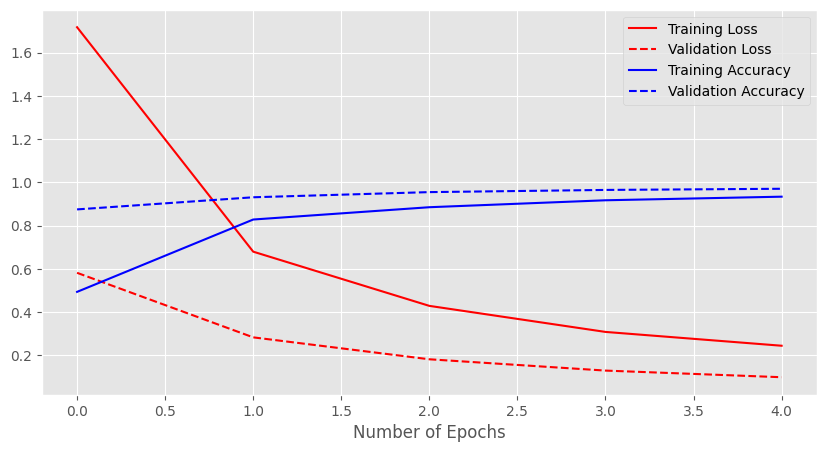

In [17]:
plot(hist)

In [18]:
print(eval_(model))

94/94 [==============================] - 7s 71ms/step - loss: 0.1810 - accuracy: 0.9553
Model Test loss : 0.18 and Test Accuracy : 0.96 


In [19]:
'''
1. Create base model
2. use imagent weights (or) else
3. Remove fully connected layers after removing now base model acts as a powerful feature extractor.
'''

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

# Frezzing all the layers which prevents the weights being updated
for layer in base_model.layers:
    layer.trainable = False

## Add new layers to the Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(15, activation='softmax')
])


early_stopping = keras.callbacks.EarlyStopping(patience=2,monitor='val_loss',restore_best_weights=True,min_delta=0.1) # Set up callbacks

## compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics='accuracy')

##fit the model
hist = model.fit(train_image_generator,
                 epochs=20,
                 verbose=1,
                 validation_data=val_image_generator,
                 steps_per_epoch = 15000//32,
                 validation_steps = 3000//32,
                 callbacks=early_stopping,
                workers=4)


Epoch 1/20
468/468 [==============================] - 105s 218ms/step - loss: 1.6495 - accuracy: 0.5226 - val_loss: 0.5954 - val_accuracy: 0.8595
Epoch 2/20
468/468 [==============================] - 99s 211ms/step - loss: 0.6676 - accuracy: 0.8313 - val_loss: 0.2855 - val_accuracy: 0.9271
Epoch 3/20
468/468 [==============================] - 101s 215ms/step - loss: 0.4199 - accuracy: 0.8899 - val_loss: 0.1854 - val_accuracy: 0.9513
Epoch 4/20
468/468 [==============================] - 102s 217ms/step - loss: 0.3096 - accuracy: 0.9141 - val_loss: 0.1295 - val_accuracy: 0.9661
Epoch 5/20
468/468 [==============================] - 103s 219ms/step - loss: 0.2388 - accuracy: 0.9321 - val_loss: 0.1030 - val_accuracy: 0.9708


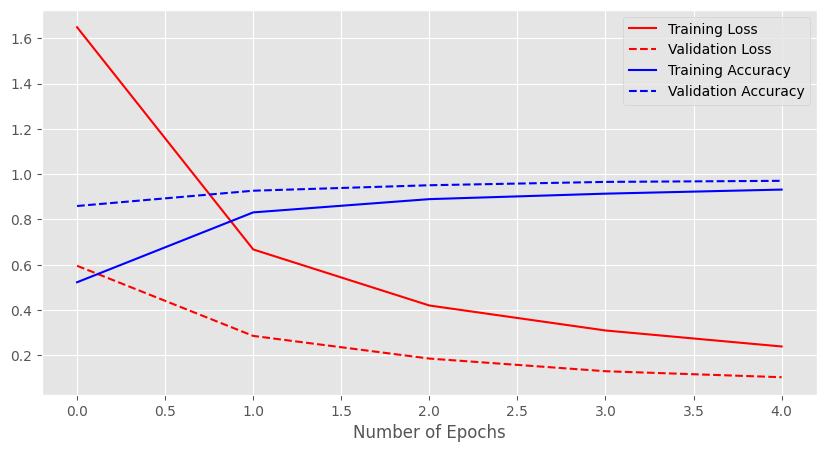

In [20]:
plot(hist)

In [21]:
eval_(model)

94/94 [==============================] - 7s 71ms/step - loss: 0.1845 - accuracy: 0.9517


'Model Test loss : 0.18 and Test Accuracy : 0.95 '

In [22]:
## Freeze A Few layers

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

# Frezzing all the layers which prevents the waits being updated
for layer in base_model.layers:
    layer.trainable = False

# unFrezzing last few layers
for layer in base_model.layers[-6:]:
    layer.trainable = True

## Add new layers to the Model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(15, activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=3,monitor='val_loss',restore_best_weights=True) # Set up callbacks

## compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics='accuracy')

##fit the model
hist = model.fit(train_image_generator,
                 epochs=50,
                 verbose=1,
                 validation_data=val_image_generator,
                 steps_per_epoch = 15000//32,
                 validation_steps = 3000//32,
                 callbacks=early_stopping,
                workers=4)


Epoch 1/50
468/468 [==============================] - 114s 234ms/step - loss: 1.9164 - accuracy: 0.3965 - val_loss: 0.4543 - val_accuracy: 0.8646
Epoch 2/50
468/468 [==============================] - 102s 217ms/step - loss: 0.2318 - accuracy: 0.9317 - val_loss: 0.0833 - val_accuracy: 0.9788
Epoch 3/50
468/468 [==============================] - 101s 215ms/step - loss: 0.1163 - accuracy: 0.9664 - val_loss: 0.0348 - val_accuracy: 0.9929
Epoch 4/50
468/468 [==============================] - 104s 221ms/step - loss: 0.0526 - accuracy: 0.9859 - val_loss: 0.1253 - val_accuracy: 0.9671
Epoch 5/50
468/468 [==============================] - 101s 215ms/step - loss: 0.0595 - accuracy: 0.9838 - val_loss: 0.1098 - val_accuracy: 0.9815
Epoch 6/50
468/468 [==============================] - 104s 222ms/step - loss: 0.0593 - accuracy: 0.9849 - val_loss: 0.0786 - val_accuracy: 0.9845


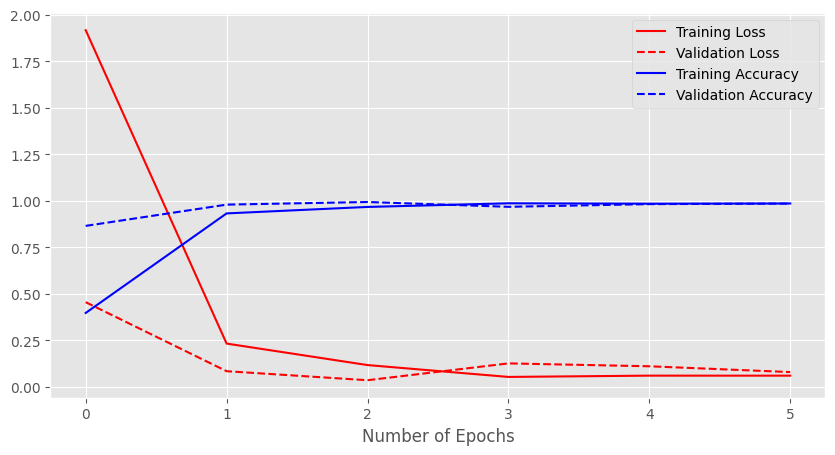

In [24]:
plot(hist)

In [23]:
eval_(model)

94/94 [==============================] - 6s 68ms/step - loss: 0.0346 - accuracy: 0.9930


'Model Test loss : 0.03 and Test Accuracy : 0.99 '

In [34]:
def predict(label,image_number):

    if label not in class_map.values() or image_number >=1000:
        print('Wrong Input 1. check if label in those 15 classes 2. image_number must be less than 1000')
    image_path = train_path + '/' + label
    images_in_folder = os.listdir(image_path)
    first_image_of_folder = images_in_folder[image_number]
    image_path += '/'+first_image_of_folder
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    test_img_input = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))
    print(class_map[np.argmax(model.predict(test_img_input))])

predict('Bitter_Gourd',7)

1/1 [==============================] - 0s 21ms/step
Bitter_Gourd


In [30]:
# Save the model
model.save("my_model.h5")


In [31]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model("my_model.h5")

# Function for predicting on new images using the loaded model
def predict_new_image(image_path, model):
    if not os.path.exists(image_path):
        print('Invalid image path. Please provide a valid path to the image.')
        return

    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    test_img_input = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))

    predicted_class = np.argmax(model.predict(test_img_input))
    print(predicted_class)


In [33]:
predict_new_image('/content/51lTK6iktYL._AC_UF1000,1000_QL80_.jpg', loaded_model)


1/1 [==============================] - 0s 18ms/step
11
